<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="../../images/DLI_Header.png"></a></div>

# DeepFM

[DeepFM](https://www.ijcai.org/Proceedings/2017/0239.pdf) is a neural network architecture built through a collaboration between Harbin Institute of Technology and Huawei. It's similar to the Wide & Deep architecture we learned before, and we can transition our model with a couple modifications.

## Objective
* Understand the logic behind DeepFM and how to create a model with it

The neural network we made with Wide & Deep performed comparatively to our Matrix Factorization model with ALS. The key advantage ALS has over Wide & Deep and normal DNNs is that it captures the interaction between users and items as a product, where as typical neural networks, no matter how many layers it has or how exotic the activation functions are, are ultimately a linear combination of features.

DeepFM tries to solve for this by including a product of features within it's architecture. Let's take a look.

<img src="DeepFM.png" height=300 width=300>

On the left of this diagram, we have our good old-fashiobed DNN. On the right, we take our embeddings and multiply their results elementwise, allowing us to have a user-item interaction. 

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, concatenate, Dense

ratings = pd.read_csv("../../data/task_2.csv")
ratings.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,reviewerID,asin,overall,unixReviewTime,brand,category_0_0,category_0_1,category_0_2,category_0_3,category_1_0,...,user_index,item_index,brand_index,als_prediction,user_embed_0,user_embed_1,item_embed_0,item_embed_1,category_0_2_index,category_1_2_index
0,A1JYQVP71WHBTL,B000089GN2,4.0,1124755200,NaN,Electronics,Computers & Accessories,Cables & Accessories,Headsets & Microphones,NaN,...,28303,2170,28303,4.301226,-3.194782,0.994011,-0.545815,0.169756,28,101
1,A3J9H77W4U792L,B000089GN2,5.0,1166918400,NaN,Electronics,Computers & Accessories,Cables & Accessories,Headsets & Microphones,NaN,...,128916,2170,128916,4.073197,-3.025520,0.940960,-1.291462,0.401487,28,101
2,A23IV3DK4EAXJH,B000089GN2,4.0,1124755200,NaN,Electronics,Computers & Accessories,Cables & Accessories,Headsets & Microphones,NaN,...,56077,2170,56077,3.985848,-2.960602,0.920899,-1.077276,0.335293,28,101
3,A93NUQAQIGU6G,B000089GN2,4.0,1104883200,NaN,Electronics,Computers & Accessories,Cables & Accessories,Headsets & Microphones,NaN,...,154651,2170,154651,3.321135,-2.466898,0.767225,-1.452197,0.451429,28,101
4,A1ZZHQHKG6G2R2,B000089GN2,5.0,1179705600,NaN,Electronics,Computers & Accessories,Cables & Accessories,Headsets & Microphones,NaN,...,51066,2170,51066,4.201225,-3.120638,0.970473,-1.051181,0.326732,28,101


Let's pull in our data pipeline from the previous lab so we can compare the results of these algorithms directly.

In [2]:
def get_ds_from_df(df_tmp, cols, label, batch_size=1024):
    dataset = (
        tf.data.Dataset.from_tensor_slices(
            (df_tmp[cols].to_dict("list"), df_tmp[label].values)
        )
        .shuffle(len(df_tmp))
        .repeat(1)
        .prefetch(1)
        .batch(batch_size)
    )
    return dataset

Next, let's build our embeddings, just like the previous lab.

In [3]:
input_user_id = Input(name="user_index", shape=(), dtype="int32")
input_product_id = Input(name="item_index", shape=(), dtype="int32")

In [4]:
input_tensor = {
    "user_index": input_user_id,
    "item_index": input_product_id
}

In [5]:
emb_user_id = Embedding(int(ratings["user_index"].max() + 1), 32)
emb_product_id = Embedding(int(ratings["item_index"].max() + 1), 32)

In [6]:
out_emb_user_id = emb_user_id(input_user_id)
out_emb_product_id = emb_product_id(input_product_id)

Here, we combine the Embedding Multiplication part of our architecture with the Dense Neural Network. [tf.keras.layers.Multiply](https://www.tensorflow.org/api_docs/python/tf/keras/layers/multiply) will allow us to do our element-wise multiplication of our embeddings.

In [7]:
# Dense Neural Network
x = tf.keras.layers.concatenate([out_emb_user_id, out_emb_product_id], axis=1)
x = tf.keras.layers.Dense(128, activation="relu", name="hidden_{}".format(1))(x)
x = tf.keras.layers.Dense(128, activation="relu", name="hidden_{}".format(2))(x)

# Embedding Multiplication
y = tf.keras.layers.Multiply()([out_emb_user_id, out_emb_product_id])

# Combine the outputs from Dense and Multiplication
x = tf.keras.layers.concatenate([x, y], axis=1)
output_tensor = tf.keras.layers.Dense(1, activation=None, name="pred")(x)

Let's vizually inspect the model to verify it's been set up correctly. We can now see where the arrows cross, showing are embeddings being used for both the Deep part of the network and the multiplication part.

In [8]:
model = tf.keras.Model(input_tensor, output_tensor)

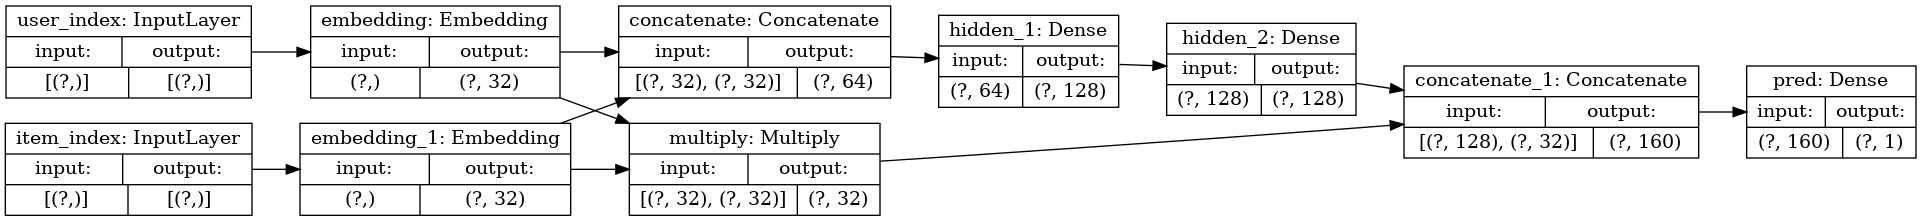

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir='LR')

Finally, let's compile and run the model to see how it compares to Wide and Deep.

In [10]:
metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")]
model.compile(optimizer="adam", loss="mse", metrics=metrics)

In [11]:
train_ds = ratings[~ratings["valid"]]
train_ds = get_ds_from_df(train_ds, ["user_index", "item_index"], "overall")

In [12]:
valid_ds = ratings[ratings["valid"]]
valid_ds = get_ds_from_df(valid_ds, ["user_index", "item_index"], "overall")

In [13]:
history = model.fit(train_ds, validation_data=valid_ds, epochs=2)

Epoch 1/2
1462/1462 [==============================] - 89s 61ms/step - loss: 1.5949 - rmse: 1.2629 - val_loss: 1.3078 - val_rmse: 1.1436
Epoch 2/2
1462/1462 [==============================] - 90s 61ms/step - loss: 1.0298 - rmse: 1.0148 - val_loss: 1.3291 - val_rmse: 1.1529


The results here are a comparable to our both our ALS and Wide and Deep models.

If we want to add contextual information, we can. Here's how we would add our ALS embeddings.

In [14]:
user_embed_0 = Input(name="user_embed_0", shape=(1), dtype="float32")
user_embed_1 = Input(name="user_embed_1", shape=(1), dtype="float32")

input_tensor = {
    "user_index": input_user_id,
    "item_index": input_product_id,
    "user_embed_0": user_embed_0,
    "user_embed_1": user_embed_1,
}

In [16]:
x = tf.keras.layers.concatenate(
    [out_emb_user_id, out_emb_product_id, user_embed_0, user_embed_1], axis=1
)
x = tf.keras.layers.Dense(128, activation="relu", name="hidden_{}".format(1))(x)
x = tf.keras.layers.Dense(128, activation="relu", name="hidden_{}".format(2))(x)

# Embedding Multiplication
y = tf.keras.layers.Multiply()([out_emb_user_id, out_emb_product_id])

# Combine the outputs from Dense and Multiplication
x = tf.keras.layers.concatenate([x, y], axis=1)
output_tensor = tf.keras.layers.Dense(1, activation=None, name="pred")(x)

In [17]:
columns = ["user_index", "item_index", "user_embed_0", "user_embed_1"]
train_ds = ratings[~ratings["valid"]]
train_ds = get_ds_from_df(train_ds, columns, "overall")
valid_ds = ratings[ratings["valid"]]
valid_ds = get_ds_from_df(valid_ds, columns, "overall")

In [18]:
model = tf.keras.Model(input_tensor, output_tensor)
model.compile(optimizer="adam", loss="mse", metrics=metrics)
history = model.fit(train_ds, validation_data=valid_ds, epochs=2)

Epoch 1/2
1462/1462 [==============================] - 92s 63ms/step - loss: 1.0114 - rmse: 1.0235 - val_loss: 1.4076 - val_rmse: 1.1864
Epoch 2/2
1462/1462 [==============================] - 98s 67ms/step - loss: 0.6798 - rmse: 0.8245 - val_loss: 1.4663 - val_rmse: 1.2109


<div align="center"><a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"><img src="../../images/DLI_Header.png"></a></div>